# Identifying county names from incomplete house addresses

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4">Data preparation</a></span></li>
<li><span><a href="#TextClassifier-model" data-toc-modified-id="TextClassifier-model-5">TextClassifier model</a></span></li>
<ul class="toc-item">
<li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-5.1">Load model architecture</a></span></li>
<li><span><a href="#Model-training" data-toc-modified-id="Model-training-5.2">Model training</a></span></li>    
<li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-5.3">Validate results</a></span></li>
<li><span><a href="#Model-metrics" data-toc-modified-id="Model-metrics-5.4">Model metrics</a></span></li>    
<li><span><a href="#Get-misclassified-records" data-toc-modified-id="Get-misclassified-records-5.5">Get misclassified records</a></span></li>
<li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-5.6">Saving the trained model</a></span></li>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-8">References</a></span></li>
</ul></div>

# Introduction

[Geocoding](https://en.wikipedia.org/wiki/Geocoding) is the process of taking input text, such as an **address** or the name of a place, and returning a **latitude/longitude** location for that place. In this notebook we will be picking up a dataset consisting of imcomplete house addresses of 10 countries. We will build a classifier using `TextClassifier` class of `arcgis.learn.text` module to predict the country for these imcomplete house addresses. 

The house addresss in the dataset consists of text in multiple languages like English, Japanese, French, Spanish etc. The dataset is a small subset of the house addresses taken from [OpenAddresses data](http://results.openaddresses.io/) 

**A note on the dataset**
- The data is collected around 2020-05-27 by [OpenAddresses](http://openaddresses.io).
- The data licenses can be found in `data/country-classifier/LICENSE.txt`.

# Prerequisites

- Data preparation and model training workflows using arcgis.learn have a dependency on [transformers](https://huggingface.co/transformers/v3.0.2/index.html). Refer to the section "Install deep learning dependencies of arcgis.learn module" [on this page](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies-for-arcgis.learn-module) for detailed documentation on installation of the dependencies.

- Labelled data: In order for `TextClassifier` to learn, it needs to see documents/texts that have been assigned a label. Labelled data for this sample notebook is located at `data/country-classifier/house-addresses.csv`

- To learn more on how `TextClassifier` works, please see the guide on [Text Classification with arcgis.learn](https://developers.arcgis.com/python/guide/text-classification-workflow).

# Imports

In [1]:
import pandas as pd
from arcgis.learn import prepare_textdata
from arcgis.learn.text import TextClassifier

# Data preparation

Data preparation involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on. The `prepare_data()` function can directly read the training samples and automate the entire process.

In [2]:
DATA_ROOT = "data/country_classifier/"

In [4]:
data = prepare_textdata(DATA_ROOT, "classification", train_file="house-addresses.csv", 
                        text_columns="Address", label_columns="Country", batch_size=64)

The `show_batch()` method can be used to see the training samples, along with labels.

In [7]:
data.show_batch(10)

Address,Country
"732P, CL ARENAL, 33740",ES
"17-9, 高柳新田",JP
"S/N, CALLE VENUSTIANO CARRANZA, NICOLÁS BRAVO, Othón P. Blanco, Quintana Roo",MX
"SN, CALLE FRONTERA, MAZATLÁN, Mazatlán, Sinaloa",MX
"41, Oostmallebaan, Zoersel, 2980",BE
"SN, RUA ENGENHO PROPRIEDADE, Sirinhaém, PE, 55580-000",BR
"Mvundlweni, The Msunduzi",ZA
"31, Boulevard de la Liberté, Draguignan, 83300",FR
"5, CL POZO PONTON, 46357",ES
"319, ALAMEDA LORENA, APARTAMENTO 64, São Paulo, SP, 01424-001",BR


# TextClassifier model

`TextClassifier` model in `arcgis.learn.text` is built on top of [Hugging Face Transformer](https://huggingface.co/transformers/v3.0.2/index.html) library. The model training and inferencing workflow is similar to computer vision models in `arcgis.learn`. 

## Load model architecture

Invoke the `TextClassifier` class by passing the data and the backbone you have choosen. The dataset consists of house addresses in multiple languages like Japanese, English, French, Spanish etc., hence we will use a [multi-lingual transformer backbone](https://huggingface.co/transformers/v3.0.2/multilingual.html) to train our model.

In [8]:
model = TextClassifier(data, backbone="xlm-roberta-base")

## Model training

The `learning rate`[1] is a **tuning parameter** that determines the step size at each iteration while moving toward a minimum of a loss function, it represents the speed at which a machine learning model **"learns"**. `arcgis.learn` includes learning rate finder, and is accessible through the model's `lr_find()` method, that can automatically select an optimum learning rate, without requiring repeated experiments.

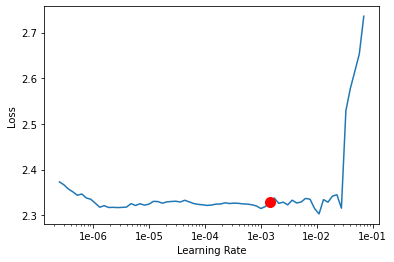

0.001445439770745928

In [9]:
model.lr_find()

Training the model is an iterative process. We can train the model using its `fit()` method till the validation loss (or error rate) continues to go down with each training pass also known as epoch. This is indicative of the model learning the task.

In [10]:
model.fit(epochs=4, lr=0.001)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.201598,0.601807,0.789600,0.210400,01:15
1,0.960644,0.381751,0.854800,0.145200,01:11
2,0.809598,0.377202,0.851000,0.149000,01:13
3,0.746876,0.339742,0.865400,0.134600,01:14


By default, the earlier layers of the model (i.e. the backbone) are frozen. Once the later layers have been sufficiently trained, the earlier layers are unfrozen (by calling `unfreeze()` method of the class) to further fine-tune the model.

In [11]:
model.unfreeze()

model.fit(epochs=6)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.313122,0.156535,0.940000,0.060000,05:36
1,0.110762,0.070600,0.969500,0.030500,05:31
2,0.057830,0.042659,0.981200,0.018800,05:22
3,0.044662,0.034602,0.985000,0.015000,05:22
4,0.034338,0.032691,0.985700,0.014300,05:26
5,0.037569,0.031471,0.986100,0.013900,05:23


## Validate results

Once we have the trained model, we can see the results to see how it performs.

In [12]:
model.show_results(15)

text,target,prediction
"SN, AVENIDA JOSE MARIA MORELOS Y PAVON OTE., APATZINGÁN DE LA CONSTITUCIÓN, Apatzingán, Michoacán de Ocampo",MX,MX
"906, AVENIDA JOSEFA ORTÍZ DE DOMÍNGUEZ, CIUDAD MENDOZA, Camerino Z. Mendoza, Veracruz de Ignacio de la Llave",MX,MX
"32, CIRCUITO JOSÉ MARÍA URIARTE, FRACCIONAMIENTO RANCHO ALEGRE, Tlajomulco de Zúñiga, Jalisco",MX,MX
"SN, ESTRADA SP 250 SENTIDO GRAMADAO, LADO DIREITO FAZENDA SAO RAFAEL CASA 4, São Miguel Arcanjo, SP, 18230-000",BR,BR
"SN, CALLE JOSEFA ORTÍZ DE DOMÍNGUEZ, RINCÓN DE BUENA VISTA, Omealca, Veracruz de Ignacio de la Llave",MX,MX
"SN, CALLE MICHOACAN, DOLORES HIDALGO CUNA DE LA INDEPENDENCIA NACIONAL, Dolores Hidalgo Cuna de la Independencia Nacional, Guanajuato",MX,MX
"SN, CALLE VERDUZCO, COALCOMÁN DE VÁZQUEZ PALLARES, Coalcomán de Vázquez Pallares, Michoacán de Ocampo",MX,MX
"1712, CALLE MÁRTIRES DEL 7 DE ENERO, CIUDAD MENDOZA, Camerino Z. Mendoza, Veracruz de Ignacio de la Llave",MX,MX
"SN, AVENIDA JACOBO GÁLVEZ, FRACCIONAMIENTO RANCHO ALEGRE, Tlajomulco de Zúñiga, Jalisco",MX,MX
"SN, ANDADOR MZNA 6 AMP. LOS ROBLES, EL PUEBLITO (CRUCERO NACIONAL), Córdoba, Veracruz de Ignacio de la Llave",MX,MX


### Test the model prediction on an input text

In [13]:
text = """1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319"""
print(model.predict(text))

('1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319', 'ES', 1.0)


## Model metrics

To get a sense of how well the model is trained, we will calculate some import metrics for out `text-classifier` model. First we will see whats the model accuracy[2] and error rate on the entire data-set. We will call the model's `accuracy()` method.

In [14]:
model.accuracy()

{'accuracy': 0.9861}

Other important metrics to look at are Precision, Recall & F-measures [3]. To find `precision`, `recall` & `f1` scores per label/class we will call the model's `metrics_per_label()` method.

In [15]:
model.metrics_per_label()

              precision    recall  f1-score   support

          AU       1.00      1.00      1.00       929
          BE       1.00      1.00      1.00      1043
          BR       1.00      1.00      1.00       950
          CA       0.90      0.97      0.94       996
          ES       1.00      1.00      1.00       982
          FR       1.00      1.00      1.00      1009
          JP       1.00      1.00      1.00       989
          MX       1.00      1.00      1.00      1024
          US       0.97      0.89      0.93      1070
          ZA       1.00      1.00      1.00      1008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Get misclassified records

Its always a good idea to see the cases where your model is not performing well. This step will help us to:
- Identify if there is a problem in the dataset.
- Identify if there is a problem with text/documents belonging to a specific label/class.  
- Identify if there is a class imbalance in your dataset, due to which the model didn't see much of the labelled data for a particular class, hance not able to learn properly about that class.

To get the **misclassified records** we will call the model's `get_misclassified_records` method.

In [16]:
misclassified_records = model.get_misclassified_records()

In [17]:
misclassified_records.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .set_properties(**{'text-align': "left"}).hide_index()

Address,Target,Prediction
"107, HAMILTON CT, EASLEY",US,CA
"40443, CHEAKAMUS WAY",CA,US
"309, SOUTH STREET, BARABOO",US,CA
"19109, DUTY ST",US,CA
"8171, CR 29, 43357",US,ES
"6565, WISCONSIN AVE",US,CA
"7332, 25TH AVENUE",US,CA
"14778, CAMINITO PUNTA ARENAS, Del Mar, 92014",US,ES
"916, PINE ST",US,CA
"168, BROAD SOUND PL, Iredell",US,CA


## Saving the trained model

Once you are satisfied with the model, you can save it using the save() method. This creates an Esri Model Definition (EMD file) that can be used for inferencing on unseen data.

In [18]:
model.save("country-classifier")

Computing model metrics...


WindowsPath('models/country-classifier')

# Model inference

The trained model can be used to classify new text documents using the predict method. This method accepts a string or a list of strings to predict the labels of these new documents/text.

In [20]:
text_list = data._train_df.sample(15).Address.values
result = model.predict(text_list)

df = pd.DataFrame(result, columns=["Address", "CountryCode", "Confidence"])

df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .set_properties(**{'text-align': "left"}).hide_index()

Address,CountryCode,Confidence
"SN, AVENIDA JUAN DE AQUINO ORIENTE, HUAMANTLA, Huamantla, Tlaxcala",MX,1.000000
"2215, COLLEGE AVE, O160, MANHATTAN, RILEY COUNTY, KS, 66502",US,0.999999
"1880, SPRING VALLEY DR, DRIPPING SPRINGS, HAYS, TX, 78620",US,1.000000
"26, Rue Charles Giraud, Onnaing, 59264",FR,1.000000
"573, RUA MANOEL LEAL, Arapiraca, AL, 57305-205",BR,1.000000
"22-2, 上吉田三丁目",JP,1.000000
"2, CL HORNO, 46260",ES,1.000000
"28, Rue Alex, Petite-Rivière-de l'Île, Gloucester",CA,0.999851
"68, Pauwel Vander Scheldenstraat, 9700",BE,1.000000
"2, CL RAFAEL ALBERTI, 47260",ES,1.000000


# Conclusion

In this notebook we will build a classifier using `TextClassifier` class of `arcgis.learn.text` module. The dataset consisted of house addresses of 10 countries written in languages like English, Japanese, French, Spanish etc. To achieve this we used a [multi-lingual transformer backbone](https://huggingface.co/transformers/v3.0.2/multilingual.html) like `XLM-RoBERTa` to build a classifier to predict the country for an input house address. 

# References

[1] [Learning Rate](https://en.wikipedia.org/wiki/Learning_rate)

[2] [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)

[3] [Precision, recall and F-measures](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures)